### Import Library

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### panggil dataset

In [3]:
sdir=r'dataset'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                       filepaths         labels
0    dataset\Sawi Ada Hama\1.png  Sawi Ada Hama
1   dataset\Sawi Ada Hama\10.png  Sawi Ada Hama
2  dataset\Sawi Ada Hama\100.png  Sawi Ada Hama
3  dataset\Sawi Ada Hama\101.png  Sawi Ada Hama
4  dataset\Sawi Ada Hama\102.png  Sawi Ada Hama
Sawi Ada Hama      500
Sawi Tanpa Hama    500
Name: labels, dtype: int64


### proses k-hold atau split dataset
- data training 80%
- data testing 10 %
- data validation 10 %

In [4]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  800   test_df length:  100   valid_df length:  100


### membuat data testing, training dan validation menggunakan ImageDataGenerator

In [5]:
height = 128
width = 128
channels = 3
batch_size = 64

# Definisi dimensi gambar
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)

# Menghitung ukuran batch optimal untuk data pengujian
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

print('test batch size:', test_batch_size, '  test steps:', test_steps)

# Membuat objek ImageDataGenerator untuk data pelatihan
gen = ImageDataGenerator(rescale=1./255)
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Membuat objek ImageDataGenerator untuk data validasi
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)

# Membuat objek ImageDataGenerator untuk data pengujian
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# Mendapatkan daftar kelas dari generator data pelatihan
classes = list(train_gen.class_indices.keys())
print(classes)

# Menghitung jumlah kelas
class_count = len(classes)


test batch size: 50   test steps: 2
Found 799 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
['Sawi Ada Hama', 'Sawi Tanpa Hama']


d:\INSTALASI\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


### menampilkan beberapa gambar dari generator

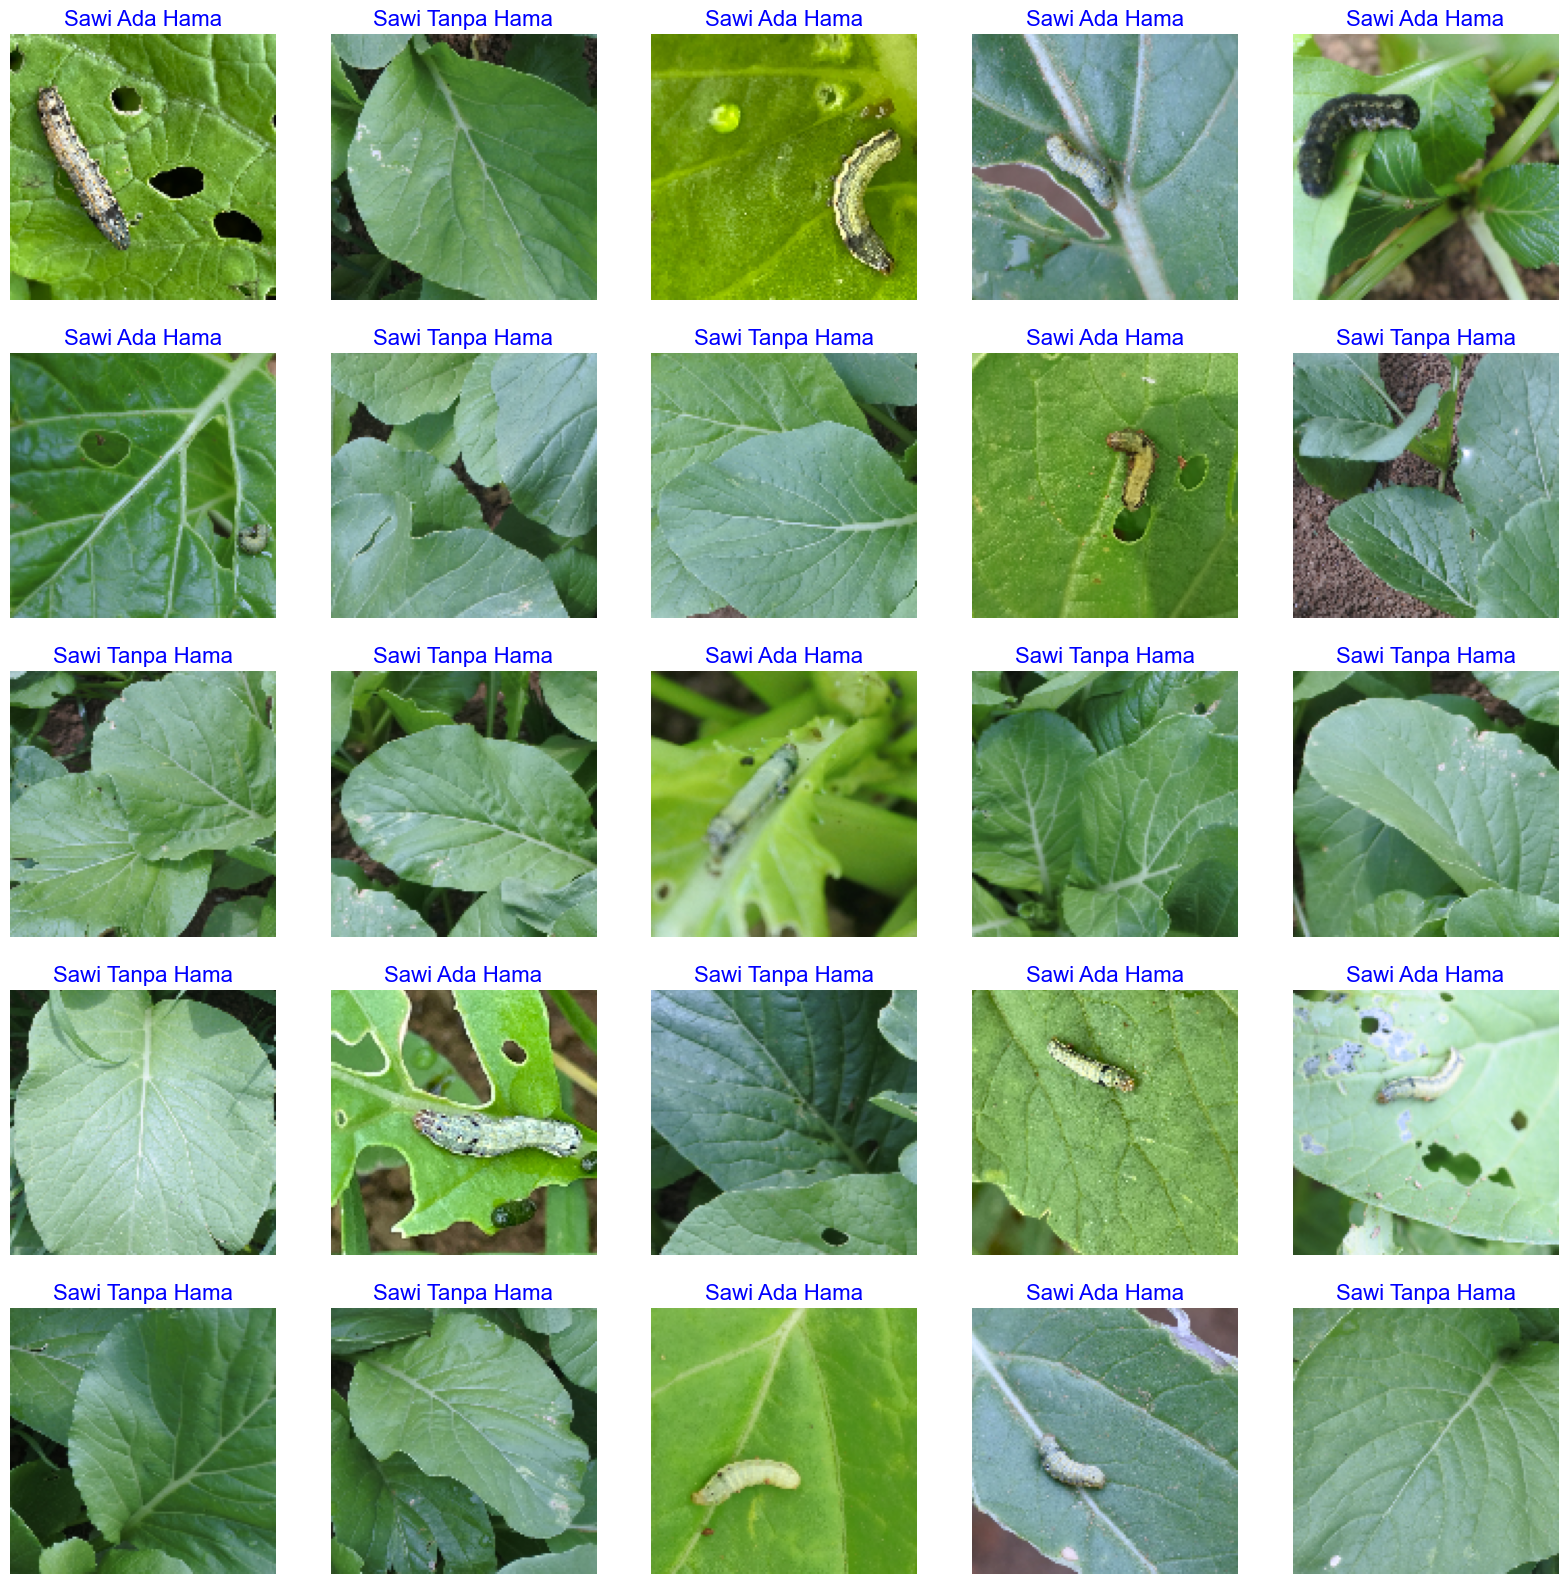

In [6]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)  # Mengambil satu batch contoh dari generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:   # Menampilkan maksimal 25 gambar
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
show_image_samples(train_gen)


### membuat model menggunakan arsitektur Xception
- include_top=False digunakan untuk menghilangkan layer fully connected (top layer) pada model, sehingga hanya mempertahankan bagian konvolusi dari Xception.
- weights="imagenet" menentukan bahwa kita ingin menggunakan bobot yang telah dilatih pada dataset ImageNet untuk model Xception
- `base_model.summary()` mencetak ringkasan (summary) dari base_model, yaitu model dasar yang telah diinisialisasi dengan arsitektur Xception.
- Ringkasan ini akan menampilkan informasi tentang lapisan-lapisan (layers) dalam model, jumlah parameter yang dapat diatur, dan jumlah parameter yang tidak dapat diatur 
- `base_model.trainable = False` digunakan untuk mengatur parameter-parameter (weights) dalam base_model menjadi tidak dapat diubah (non-trainable). Dengan mengatur trainable menjadi False, kita mematikan kemampuan model untuk melakukan pembelajaran berbasis gradient (gradient-based learning), sehingga bobot-bobot yang ada dalam model tidak akan diperbarui selama proses pelatihan.

In [7]:
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_tensor=Input(shape=(128, 128, 3)))
base_model.summary()
base_model.trainable = False

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

### cetak model
-  nama model  `sawi`
- `mode.compile` untuk optimasi model dengan optimizer `Adam`


In [8]:
model_name = 'sawi'
print("Building model with", base_model)

model = tf.keras.Sequential([
    # bentuk input adalah ukuran gambar yang diinginkan 128x128 dengan 3 byte warna
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')


Building model with <keras.engine.functional.Functional object at 0x0000017D8048BA00>


### melatih model menggunakan data train selama 10 epoch

In [9]:
epochs = 10

history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)


Epoch 1/10
13/13 [==============================] - 78s 6s/step - loss: 0.3768 - accuracy: 0.8385 - val_loss: 0.1198 - val_accuracy: 0.9600
Epoch 2/10
13/13 [==============================] - 86s 7s/step - loss: 0.1684 - accuracy: 0.9412 - val_loss: 0.1312 - val_accuracy: 0.9400
Epoch 3/10
13/13 [==============================] - 89s 7s/step - loss: 0.1132 - accuracy: 0.9625 - val_loss: 0.1625 - val_accuracy: 0.9500
Epoch 4/10
13/13 [==============================] - 72s 6s/step - loss: 0.1316 - accuracy: 0.9474 - val_loss: 0.1095 - val_accuracy: 0.9700
Epoch 5/10
13/13 [==============================] - 77s 6s/step - loss: 0.0736 - accuracy: 0.9700 - val_loss: 0.1096 - val_accuracy: 0.9700
Epoch 6/10
13/13 [==============================] - 79s 6s/step - loss: 0.0742 - accuracy: 0.9712 - val_loss: 0.1863 - val_accuracy: 0.9200
Epoch 7/10
13/13 [==============================] - 81s 6s/step - loss: 0.0525 - accuracy: 0.9825 - val_loss: 0.1309 - val_accuracy: 0.9600
Epoch 8/10
13/13 [==

### cetak teks dengan background RGB

In [10]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # Mencetak pesan teks (txt_msg) dengan warna latar depan (fore_tupple) dan latar belakang (back_tupple) yang ditentukan.
    # txt_msg adalah teks yang akan dicetak, fore_tupple adalah tupel warna latar depan (r, g, b), back_tupple adalah tupel warna latar belakang (r, g, b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # Mengembalikan warna cetakan default menjadi hitam
    return


### metode plot grafik training & validation

In [13]:
def tr_plot(tr_data, start_epoch):
    # Plotting data pelatihan dan validasi
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i+1)
    index_loss = np.argmin(vloss)  # epoch dengan val_loss terendah
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch = ' + str(index_acc + 1 + start_epoch)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


### melakukan evaluasi prediksi model 

In [11]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    
    # Membentuk dictionary baru dengan urutan integer kelas sebagai kunci dan nama kelas sebagai nilai
    for key, value in class_dict.items():
        new_dict[value] = key
    
    # Menyimpan new_dict sebagai file teks di save_dir
    classes = list(new_dict.values())
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    
    errors = 0
    
    # Melakukan evaluasi prediksi dan mencatat kesalahan prediksi
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1
        y_pred.append(pred_index)
    
    # Mencetak informasi kesalahan prediksi jika print_code bukan 0
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Nama File', 'Kelas Prediksi', 'Kelas Sebenarnya', 'Probabilitas')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'Dengan akurasi 100%, tidak ada kesalahan yang dicetak.'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    
    # Mencetak grafik jumlah kesalahan per kelas jika ada kesalahan
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        plt.title('Kesalahan per Kelas pada Dataset Uji')
    
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    
    # Mencetak matriks kebingungan jika jumlah kelas <= 30
    if len(classes) <= 30:
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Prediksi")
        plt.ylabel("Aktual")
        plt.title("Matriks Kebingungan")
        plt.show()
    
    # Mencetak laporan klasifikasi
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Laporan Klasifikasi:\n----------------------\n", clr)


### Evaluasi nilai akurasi model dan menampilkan grafik akurasi 

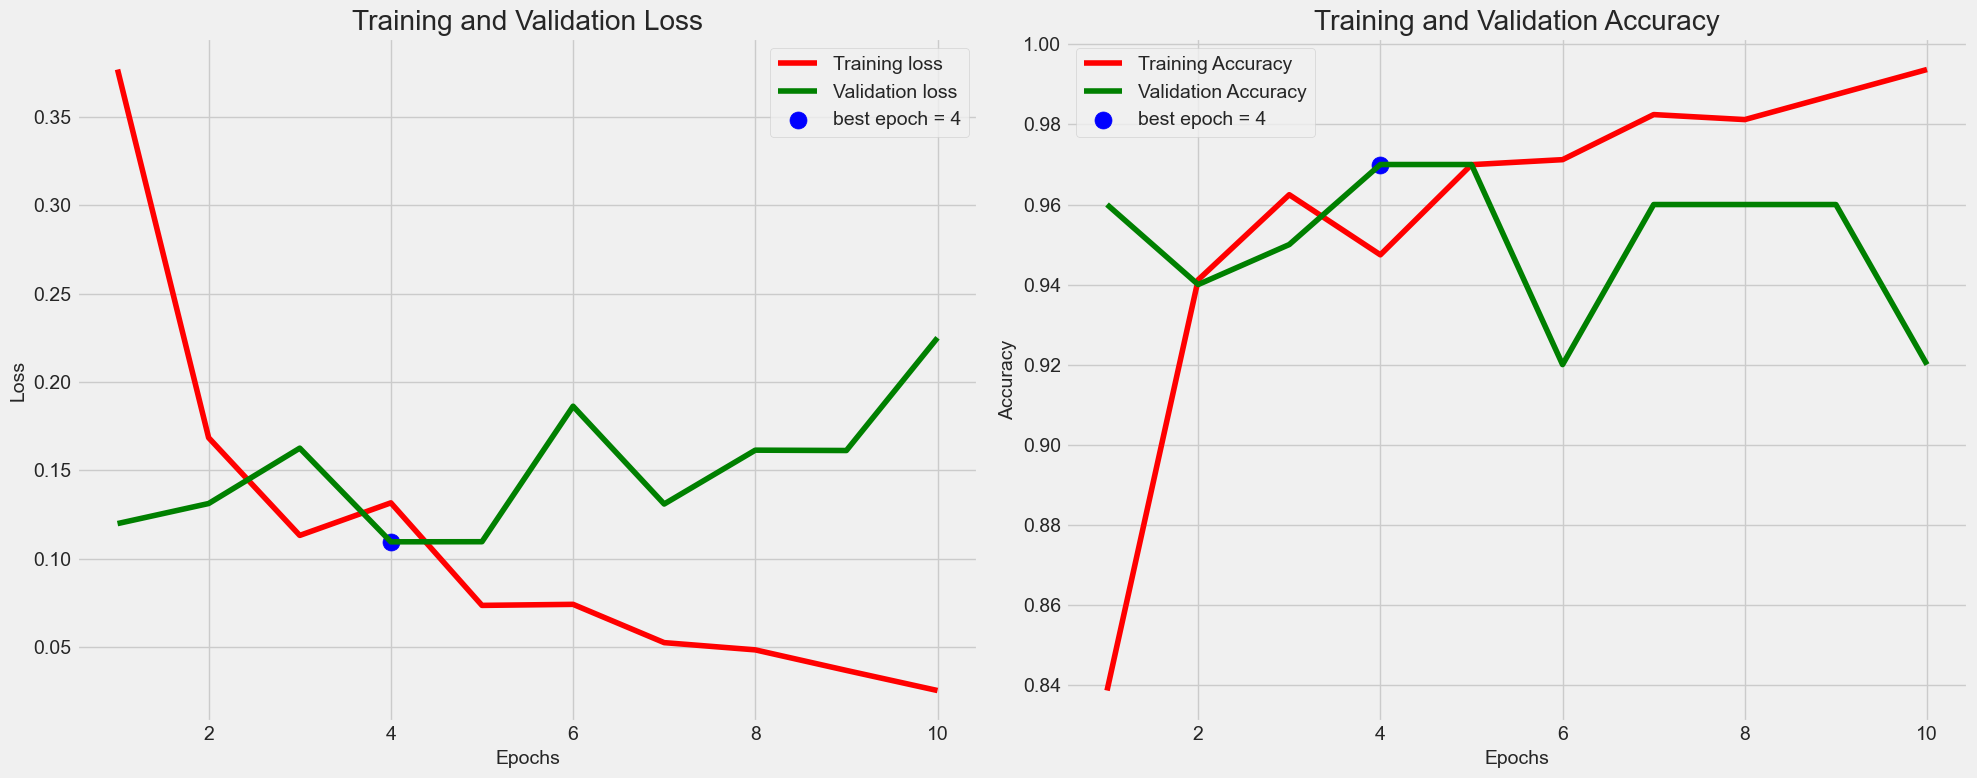

2/2 [==============================] - 10s 6s/step - loss: 0.0743 - accuracy: 0.9800
Akurasi pada dataset pengujian adalah 98.00 %



In [14]:
tr_plot(history, 0)
save_dir = r'./'
subject = 'model'

# Evaluasi akurasi model pada dataset pengujian
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100

# Mencetak informasi akurasi pada dataset pengujian
msg = f'Akurasi pada dataset pengujian adalah {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Menyimpan model dengan format nama tertentu
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)


### mencetak informasi tentang hasil prediksi dan menampilkan laporan klasifikasi serta confusion matrix

2/2 [==============================] - 12s 4s/step


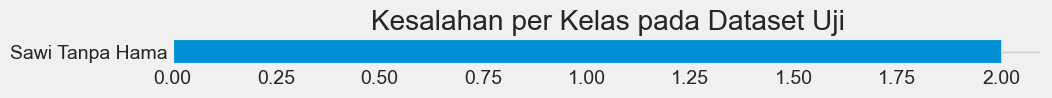

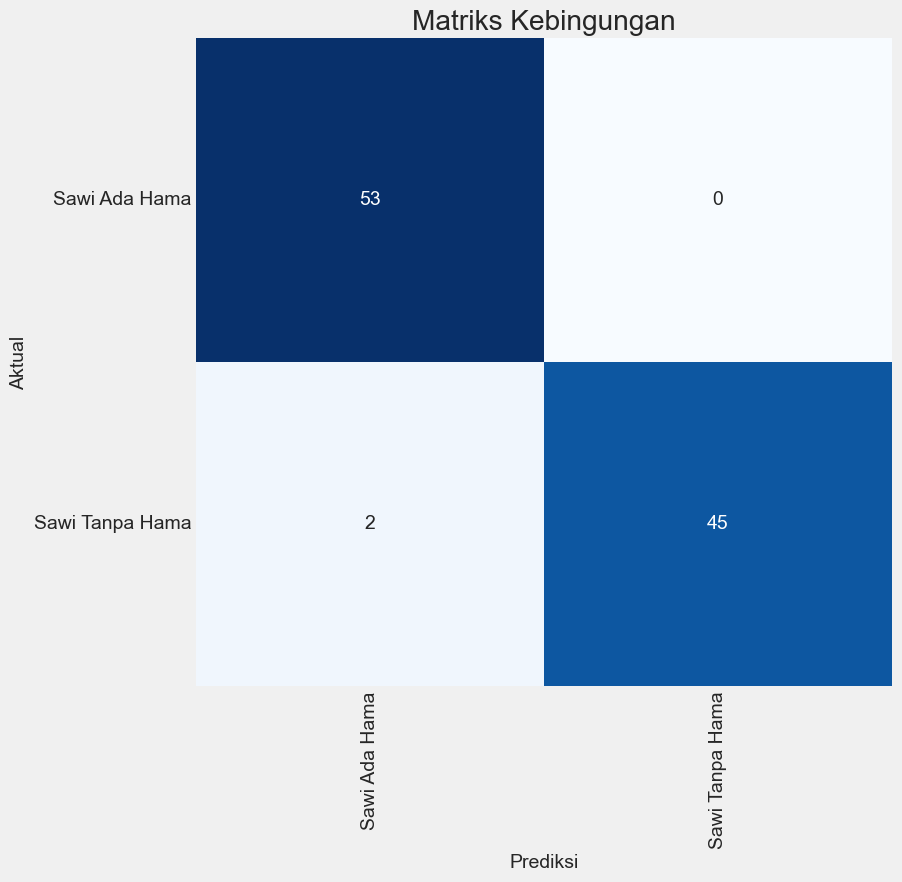

Laporan Klasifikasi:
----------------------
                  precision    recall  f1-score   support

  Sawi Ada Hama       0.96      1.00      0.98        53
Sawi Tanpa Hama       1.00      0.96      0.98        47

       accuracy                           0.98       100
      macro avg       0.98      0.98      0.98       100
   weighted avg       0.98      0.98      0.98       100



In [15]:
print_code = 0
preds = model.predict(test_gen)
print_info(test_gen, preds, print_code, save_dir, subject)
